## Introduction
This competition is hosted by a large grocery company in Ecuador called "Corporacion Favorita" where the aim of the game is to accurately predict and forecast the unit sales for items sold at various Favorita supermarker chains across Ecuador. Apart from the usual training and test data files provided, there are also quite a handful of supplementary data files(5) provided to us.  
  
  This Notebooks aims to take a deep-dive analysis into each of the files provided in this competition and to investigate what types of insights or observations can be dervied from each. The structure of this analysis is as follows:
1. **Data loading and inspection**- Loading the data as Python dataframes and conducting data quality checks

2. **Supplementary Data exploration** - Exploration of all 5 supplementary files with a mix of D3.js visualizations and stacked barplots

3. **Training data exploration**

4. **Feature ranking with learning models** - Training a

## 1.Data loading and Inspection checks
To start off with, let us load in the various supplemetary comma-seperated value files with the Pandas package via the read_csv function as folllows. 
  
  With regards to the training data, it contains a whooping 125.5 million rows(and 6 columns). Therefore I will load only **6 million rows**(approx 5% of the data) just to get a rough idea of what is in store for us.

In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import IPython.display
import json
import seaborn as sns
import squarify
%matplotlib inline
import missingno as msno
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from matplotlib import pyplot as plt
import seaborn

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z


In [2]:
!pip install py7zr

     |████████████████████████████████| 65 kB 160 kB/s eta 0:00:011
     |████████████████████████████████| 13.7 MB 2.2 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
os.listdir('/kaggle/input/favorita-grocery-sales-forecasting/')

['stores.csv.7z',
 'transactions.csv.7z',
 'sample_submission.csv.7z',
 'holidays_events.csv.7z',
 'items.csv.7z',
 'train.csv.7z',
 'oil.csv.7z',
 'test.csv.7z']

In [4]:
from py7zr import unpack_7zarchive
import shutil
shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
for f in os.listdir('/kaggle/input/favorita-grocery-sales-forecasting/'):
    shutil.unpack_archive(f'/kaggle/input/favorita-grocery-sales-forecasting/{f}', '/kaggle/data/')

In [5]:
# !7za e /kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
# !python -m py7zr x /kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
# !py7zr x /kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z /kaggle/working/

In [6]:
path = '/kaggle/data/'
!ls {path}

holidays_events.csv  oil.csv		    stores.csv	train.csv
items.csv	     sample_submission.csv  test.csv	transactions.csv


In [7]:
types = {'id': 'int64',
        'item_nbr': 'int32',
        'store_nbr': 'int8',
        'unit_sales': 'float32',
        'onpromotion': 'object'}

In [8]:
%%time
train = pd.read_csv('/kaggle/data/train.csv', parse_dates=['date'],
                    dtype=types, infer_datetime_format=True)

CPU times: user 1min 8s, sys: 12 s, total: 1min 20s
Wall time: 1min 20s


In [9]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


Taking a peak, we note that the training data consists only of 6 measly columns and coupled wih the fact that we have 125 million rows, there deos seem to be a discrepency in the number of features that we are going to provide our learning model to train on. However that's where the other supplementary files come into play. There is lot of potential and avenues for feature enchancment and engineering.

In [10]:
table_names1 = ['stores', 'items']
tables1 = [pd.read_csv(f'{path}/{f}.csv', low_memory=False) for f in table_names1]
stores, items = tables1

In [11]:
table_names = ['holidays_events', 'oil', 'transactions', 'test']
tables = [pd.read_csv(f'{path}/{f}.csv', parse_dates = ['date'], infer_datetime_format=True) for f in table_names]
holidays, oil, transactions, test = tables
len(tables)

4

In [12]:
### Null or missing values check
print("Nulls in Oil columns: {0} ->{1}".format(oil.columns.values, oil.isnull().any().values))
print('='*50)
print('Nulls in holidays columns: {0} -> {1}'.format(holidays.columns.values, holidays.isnull().any().values))
print('='*50)
print('Nulls in stores columns: {0} -> {1}'.format(stores.columns.values, stores.isnull().any().values))
print('='*50)
print('Nulls in transcations columns: {0} -> {1}'.format(transactions.columns.values, transactions.isnull().any().values))
print('='*50)
print('Nulls in items columns: {0} -> {1}'.format(items.columns.values, items.isnull().any().values))


Nulls in Oil columns: ['date' 'dcoilwtico'] ->[False  True]
Nulls in holidays columns: ['date' 'type' 'locale' 'locale_name' 'description' 'transferred'] -> [False False False False False False]
Nulls in stores columns: ['store_nbr' 'city' 'state' 'type' 'cluster'] -> [False False False False False]
Nulls in transcations columns: ['date' 'store_nbr' 'transactions'] -> [False False False]
Nulls in items columns: ['item_nbr' 'family' 'class' 'perishable'] -> [False False False False]


As we can see, data is only missing in the oils table, which provides the dails price for oil.

 ## 2.Supplementary Data Exploration

### 2a. Oil data

In [13]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [14]:
## Scatter plot 
trace = go.Scatter(name="Oil prices",
                  x= oil['date'],
                  y=oil['dcoilwtico'].dropna(),
                  mode='lines',
                  line=dict(color='rgb(20, 12, 210, 0.8)'),
                  fillcolor='rgba(68, 68,68, 0.3)',
                  fill='tonexty')
data = [trace]
layout = go.Layout(yaxis=dict(title='Daily oil price'),
                  title='Daily oil prices from Jan 2013 till July 2017',
                  showlegend = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='pandas-time-series-error-bars')

> ### 2b. Stores data

With regards to the "stores.csv" file, the data dictionary on the Kaggle competition simply states that it contains metadata on the city, state, the store type and a column termed "cluster". Now this cluster column is a grouping to stores that are similar to each other and as we can see from the latter analysis, there are a total of 17 distinct clusters. With regards to the number of stores, there are a total of 54 stores (based off a unique list of store_nbr) and therefore I presume that all the unit sales and transactions are generated off the data collected from these 54 stores.

In [15]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [16]:
stores['cluster'].nunique()

17

**Treemap plots**

In [17]:
stores.city.value_counts().to_frame()[:5]

,city
Quito,18
Guayaquil,8
Santo Domingo,3
Cuenca,3
Ambato,2


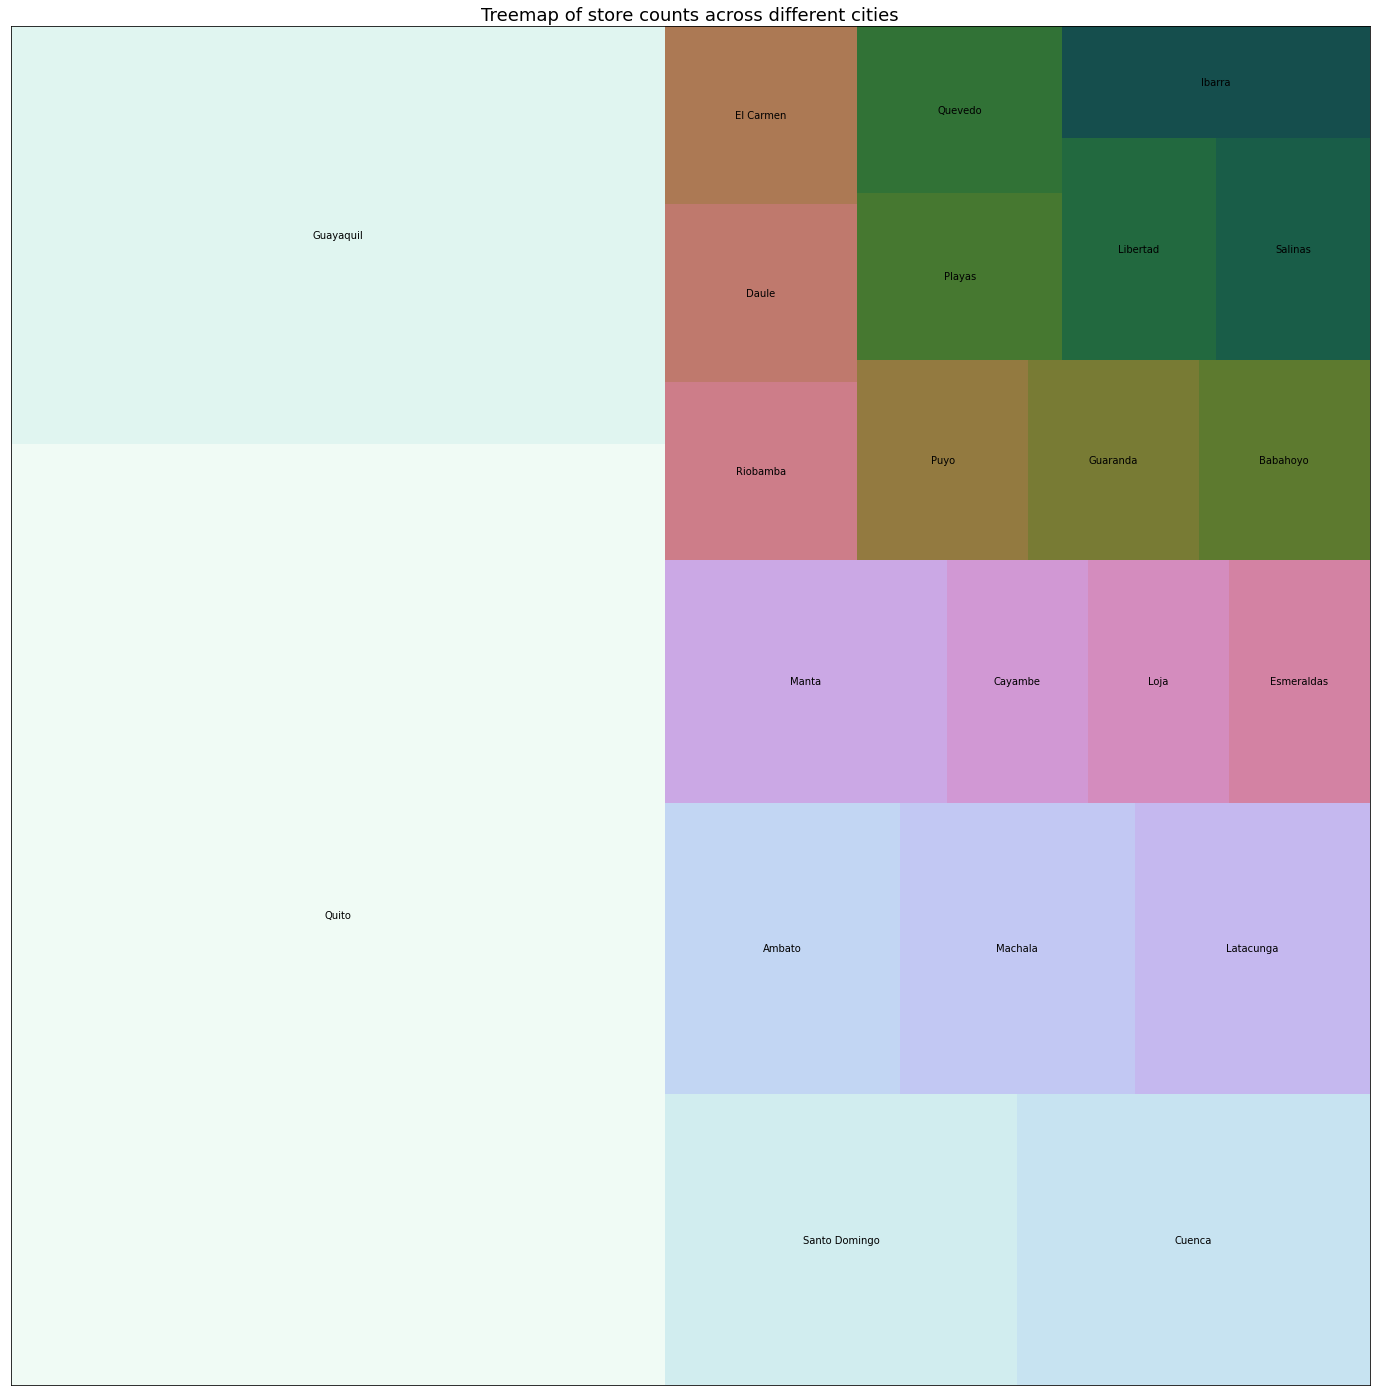

In [18]:
fig = plt.figure(figsize=(25,21))
marrimeko = stores.city.value_counts().to_frame()
ax = fig.add_subplot(111, aspect='equal')
ax = squarify.plot(sizes=marrimeko['city'].values, label=marrimeko.index, color=sns.color_palette('cubehelix_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig = plt.gcf()
fig.set_size_inches(40,25)
plt.title('Treemap of store counts across different cities', fontsize=18)
plt.show();

In [19]:
stores.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

**Inspecting the allocation of clusters to store numbers**  
We can now generate will be that of our store numbers ordered against their respective store clusters so that we can observe if there are any apparent trends or relationships in the data. To do so, I will take our stores Python dataframe and group it based on the columns "store_nbr" and "cluster" via the groupby and pivot statement. After which, I will unstack the grouping which means that I will pivot on the level of store_nbr index labels, returning a DataFrame having a new level of columns which are the store clusters whose inner-most level relate to the pivoted store_nbr index labels. This technique is commonly used for producing stacked barplots in Python but since we only have unique store_nbr numbers, therefore we will simply get barplots of store numbers ordered by their relevant clusters

Text(0.5, 1.0, 'Store numbers and the clusters they are assigned to ')

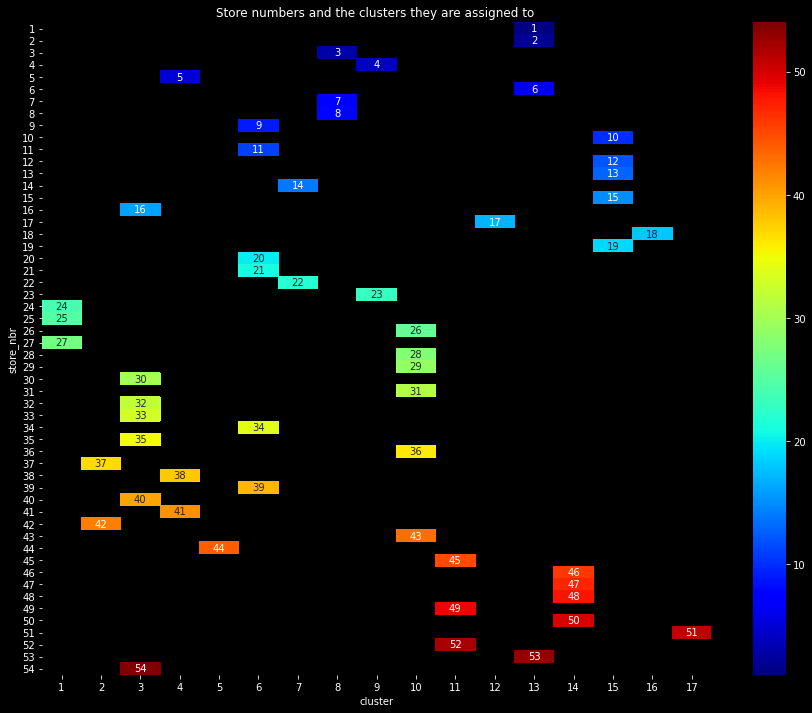

In [20]:
plt.style.use('dark_background')
plt.figure(figsize=(15,12))
store_pivot = stores.dropna().pivot('store_nbr', 'cluster', 'store_nbr')
ax = sns.heatmap(store_pivot, cmap='jet', annot=True, linewidths=0, linecolor='white')
plt.title('Store numbers and the clusters they are assigned to ')

**Takeaways from this plot**  
We can see that clusters 3, 10, 6 and 15 are the most common clusters whereas clusters 5 and 17 only have one store_no each attributed to them.  
  
  **Stacked barplots of Types against clusters**  
  Here it might be informative to look at the distribution of clusters based on the store type to see if we can identify any apparent relationship between types and the way the company has decided to cluster the particular store. Again we apply the groupby operation but this time on type and on cluster. This time when we pivot based off this grouped operation, we are able to get counts of each distinct cluster distributed and stacked on top of other clusters per store type as follows:

In [21]:
stores.type.unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

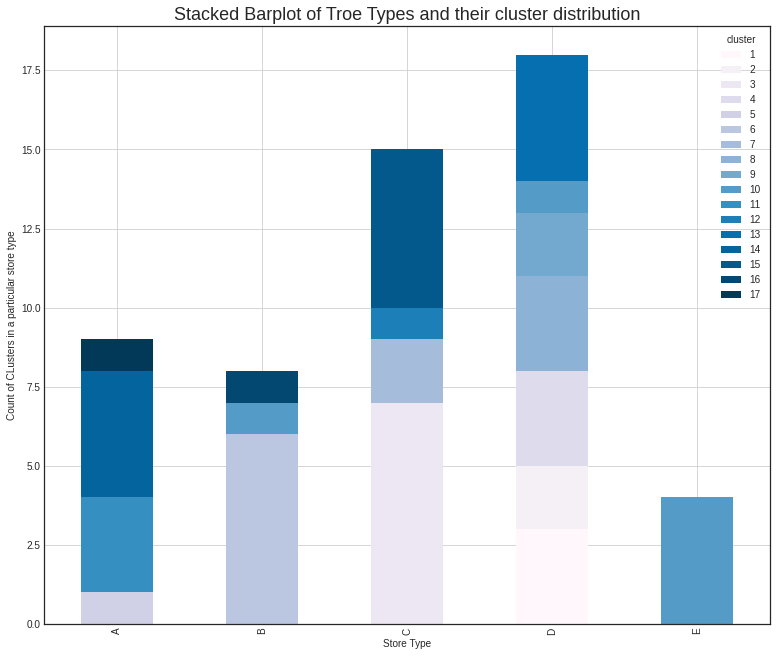

In [22]:
plt.style.use('seaborn-white')
# plt.style.use('dark_background')
type_cluster = stores.groupby(['type', 'cluster']).size()
type_cluster.unstack().plot(kind='bar', stacked=True, colormap='PuBu', figsize=(13,11), grid=True)
plt.title('Stacked Barplot of Troe Types and their cluster distribution', fontsize=18)
plt.xlabel('Store Type')
plt.ylabel('Count of CLusters in a particular store type')
plt.show()

**Takeaway**  
Most of the store types seem to contain a mix of clusters, especially with regards to store type 'D'. Only 'E' stores seem to fall under a single cluster 10. However, with regards to our initial plan of trying to find out relationships between store types and clusters, it seems that there is nothing apparent that stands out. If we think of store types, one would normally think of categories such as convenience store types, huge general store types or bulk buy types.  
  
  **Stacked barplot of types of stores against different cities**  
  ANother interesting distribution to observe would be the types of stores that Corporacion Favorita has decided to open for each city in Ecuador as well a the absolute number of stores in the city. All these three things can be acheived by turning to our usual groupby operation and pivoting again by unstacking and plotting as follows:

In [23]:
stores.columns.values

array(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype=object)

In [24]:
stores.groupby(['city', 'type']).store_nbr.size().unstack()

type,A,B,C,D,E
city,,,,,
Ambato,1.0,NaN,NaN,1.0,NaN
Babahoyo,NaN,1.0,NaN,NaN,NaN
Cayambe,NaN,1.0,NaN,NaN,NaN
Cuenca,NaN,1.0,NaN,2.0,NaN
Daule,NaN,NaN,NaN,1.0,NaN
El Carmen,NaN,NaN,1.0,NaN,NaN
Esmeraldas,NaN,NaN,NaN,NaN,1.0
Guaranda,NaN,NaN,1.0,NaN,NaN
Guayaquil,1.0,1.0,2.0,2.0,2.0


Text(0.5, 0, 'City')

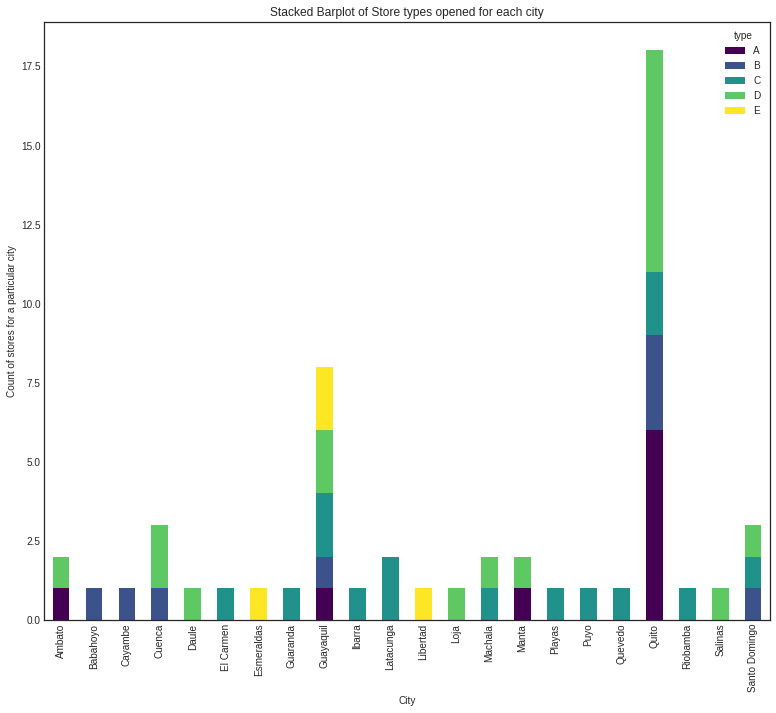

In [25]:
plt.style.use('seaborn-white')
city_cluster = stores.groupby(['city', 'type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar', stacked=True, colormap='viridis', figsize=(13,11), grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.xlabel('City')

**Takeways**  
We can see that there are 2 cities that standout in terms of the variety of store types- Guayaquil and Quito. These should come as no surprise as Quito is the CAPTIAL of Ecuador and Guayaquil is the msot populous city in the country. Therefore one would think its logical to expect the company to target these major cities with the most diverse store types probably to capture different ends of the market(if we think of store types as high end, premium, wholesale, discount etc) as well as opening up the highest number of stores evinced from the largest count of sotre_nbrs attributed to those two cities.

### 2c.Hoildays Data

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

In [26]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [27]:
holidays.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

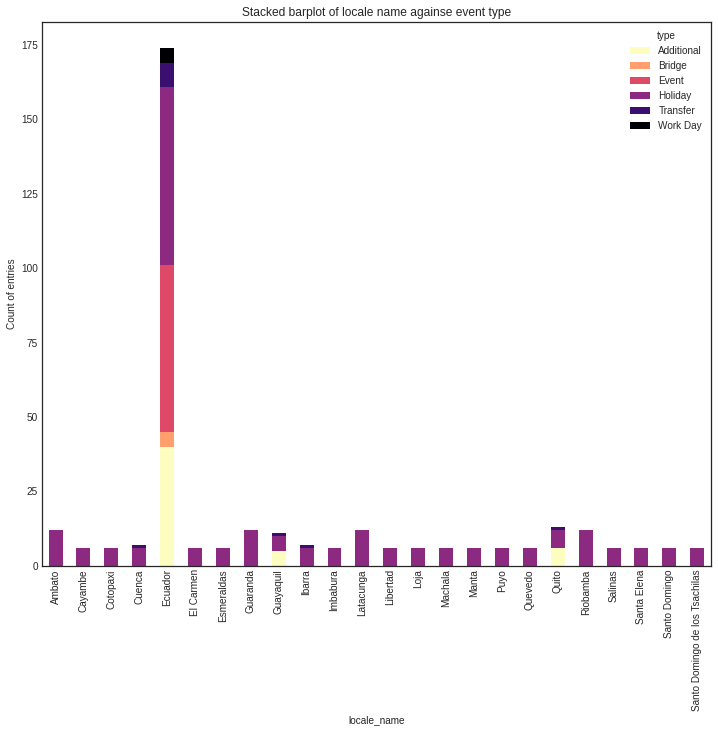

In [28]:
plt.style.use('seaborn-white')
# plt.style.use('dark_background')
holiday_local_type = holidays.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar', stacked=True, colormap='magma_r', figsize=(12,10), grid=False)
plt.title('Stacked barplot of locale name againse event type')
plt.ylabel('Count of entries')
plt.show()

 ### 2d. Transactions data  
 **Periodicity in transaction pattern**  
 Inspecting the transactions file, we must be aware that the transactional data is only included for the training timeframe according to the competition's data dictionary.

In [29]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [30]:
transactions.shape

(83488, 3)

In [31]:
transactions.date = transactions.date.dt.date

In [32]:
transactions.date.values

array([datetime.date(2013, 1, 1), datetime.date(2013, 1, 2),
       datetime.date(2013, 1, 2), ..., datetime.date(2017, 8, 15),
       datetime.date(2017, 8, 15), datetime.date(2017, 8, 15)],
      dtype=object)

In [33]:
type(transactions.date)

pandas.core.series.Series

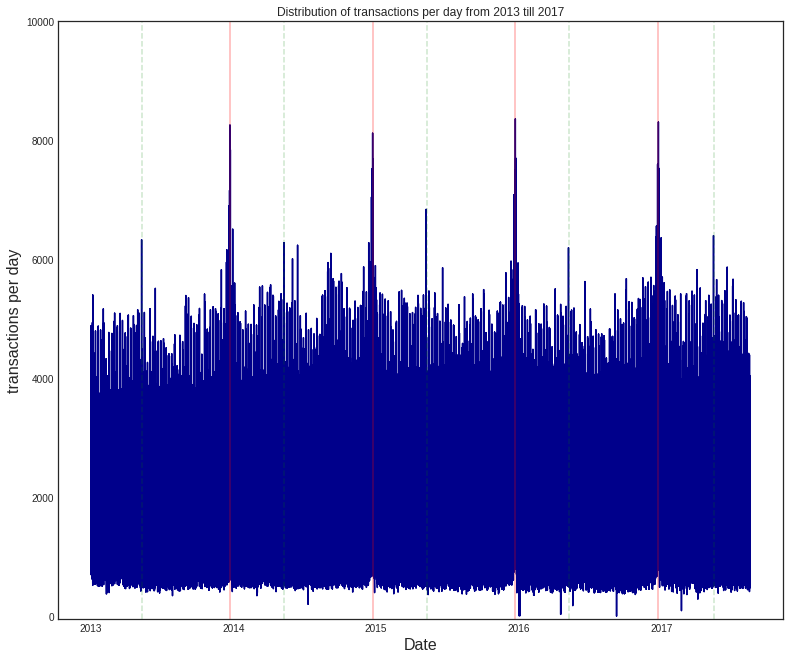

In [34]:
import datetime as dt
plt.figure(figsize=(13,11))
plt.plot(transactions.date.values, transactions.transactions.values, color='darkblue')
plt.axvline(dt.datetime(2015, 12, 23) ,color='red',alpha=0.3)
plt.axvline(dt.datetime(2016, 12, 23),color='red',alpha=0.3)
plt.axvline(dt.datetime(2014, 12, 23),color='red',alpha=0.3)
plt.axvline(dt.datetime(2013, 12, 23),color='red',alpha=0.3)
plt.axvline(dt.datetime(2013, 5, 12),color='green',alpha=0.2, linestyle= '--')
plt.axvline(dt.datetime(2014, 5, 11),color='green',alpha=0.2, linestyle= '--')
plt.axvline(dt.datetime(2015, 5, 10),color='green',alpha=0.2, linestyle= '--')
plt.axvline(dt.datetime(2016, 5, 8),color='green',alpha=0.2, linestyle= '--')
plt.axvline(dt.datetime(2017, 5, 14),color='green',alpha=0.2, linestyle= '--')
plt.ylim(-50, 10000)
plt.title("Distribution of transactions per day from 2013 till 2017")
plt.ylabel('transactions per day', fontsize= 16)
plt.xlabel('Date', fontsize= 16)
plt.show()

`**Takeaways from the above plot**  
Interestingly when plotting interactions on a year to year basis, we can already pick out two different periodic spikes in transactions from the data(one in the red line and the other in the green). The bigger yearly periodic spike in transactions seem to occur at the end of the year in December, specifically on the 23 December every year-end. Perhaps this is due to some sort of Christmas sale/discount that the company holds in December every year, thereby expaining the bump in transactions on this date. The weaker periodic spike given by the green dotted lines seem to occur in the middle of the months of May, specifically on the sunday in the second week of May. Perhaps another similar scheme is being implemented by the Company on those sundays.

### 2e. Items data

Moving onto the items.csv file, we can see that there are not many columns in the data. There is a unique item number identifier "item-nbr" which we presume relates to mappings to grocery items such as "HOusebrand tomatoes pack of 6" or "4 blueberry muffins" etc. The family column is pretty self-explanatory in the sense that this relates to parent category that the particular item relates to.

In [35]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


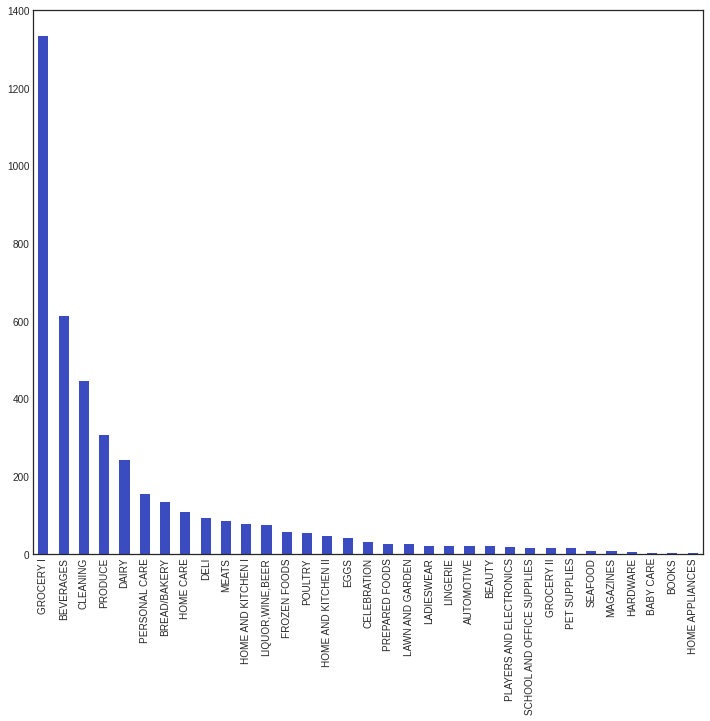

In [36]:
items.family.value_counts().plot(kind='bar', colormap='coolwarm', figsize=(12,10), grid=False)
plt.show()

**Takeaways from the plot**

As we can see from this barplot, the y-axis shows the counts of items while the x-axis displays the different family categories that the various retail items fall under, sorted from largest number of item counts to smallest number of items. As we can see from the plot, the top 3 family categories are the GROCERY I, BEVERAGES and CLEANING categories.

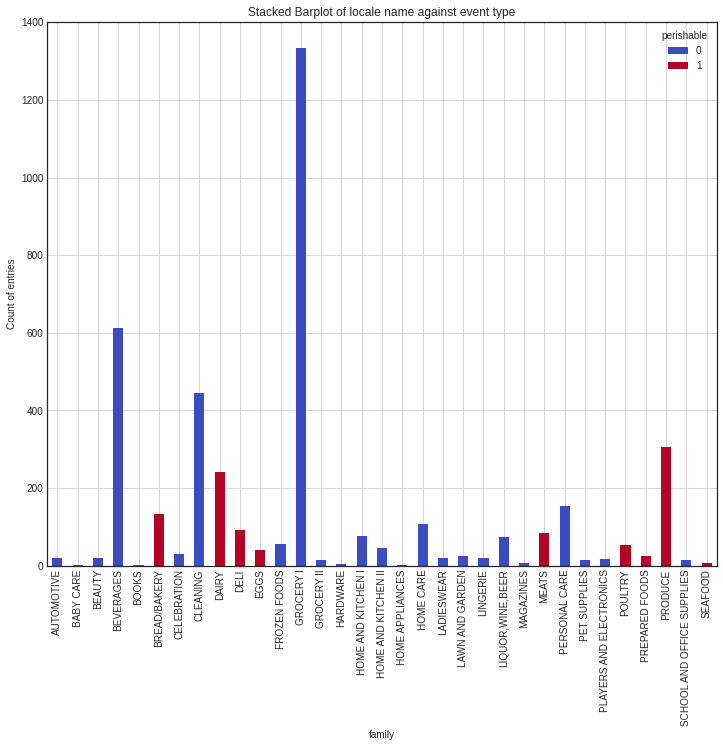

In [37]:
plt.style.use('seaborn-white')
fam_perishable = items.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12,10), grid=True)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

## 3.Training data exploration

In [38]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


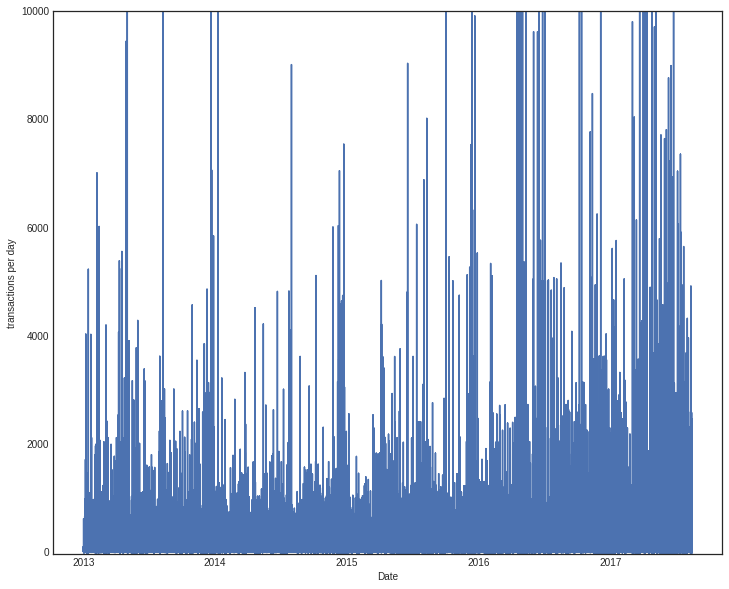

In [39]:
plt.style.use('seaborn-deep')
plt.figure(figsize=(12,10))
plt.plot(train.date.values, train.unit_sales.values)
plt.ylim(-50, 10000)
plt.ylabel('transactions per day')
plt.xlabel('Date')
plt.show()

### Store #47
The chain established itself in Quito in 1952, so let's pick a shop in Quito for some analysis. With a well established store, we can predict that the time series will be almost stationary. High seasonality is expected too, as people consume more during celebration periods. Let's see what we get.

In [40]:
sales=pd.merge(transactions,stores,how='left')
sales.head()

,date,store_nbr,transactions,city,state,type,cluster
0,2013-01-01,25,770,Salinas,Santa Elena,D,1
1,2013-01-02,1,2111,Quito,Pichincha,D,13
2,2013-01-02,2,2358,Quito,Pichincha,D,13
3,2013-01-02,3,3487,Quito,Pichincha,D,8
4,2013-01-02,4,1922,Quito,Pichincha,D,9


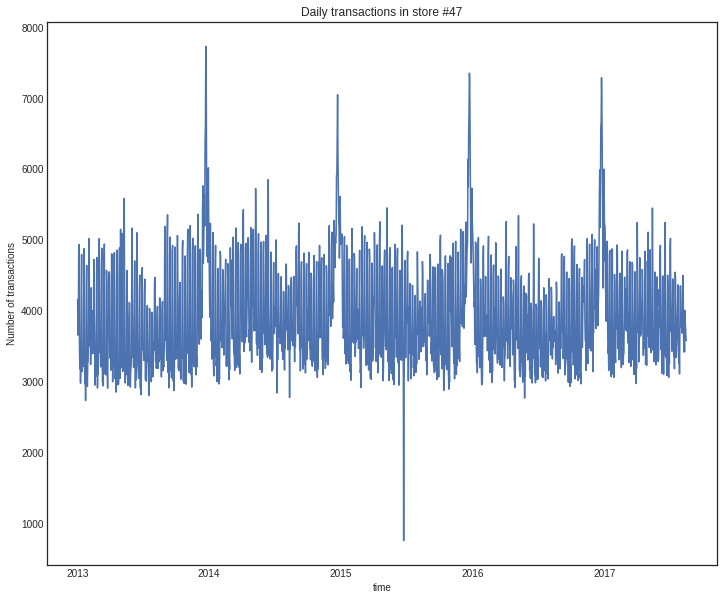

In [116]:
ts = sales.loc[sales['store_nbr'] == 47, ['date', 'transactions']].set_index('date')
ts = ts.transactions.astype('float')
plt.figure(figsize=(12,10))
plt.title('Daily transactions in store #47')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(ts)

**Seasonality and outliers**  
We can easily identify a peak around Christmas, a very low volume day mid 2015 and a fairly stable behaviour in between. The surge in volume around Christmas was expected, but what happended in mid 2015? As it turns out it corresponds to a giant national protest in Ecuador, which will most likely impact other stores as well.  
  
  We can also see that outside of this holiday period, the transactions have quite a lot of variance, hte volume oscillating between 3000 and 5000. Let's check the rolling mean and std with a window of a month.

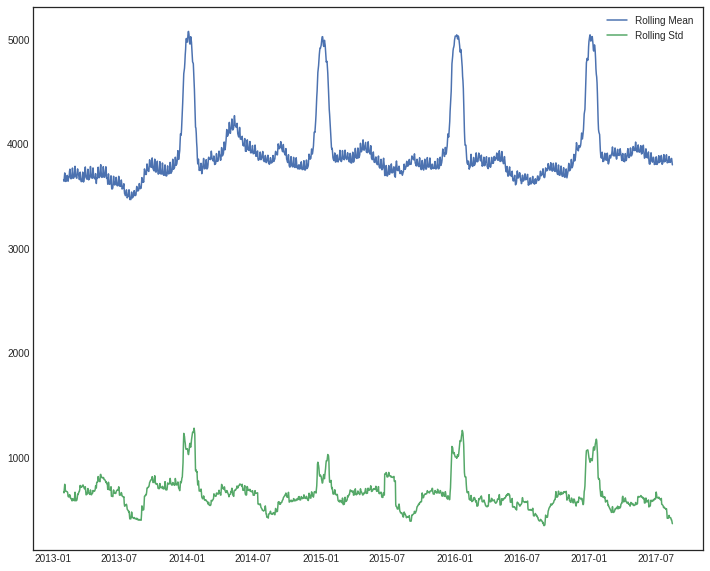

In [42]:
plt.figure(figsize=(12,10))
plt.plot(ts.rolling(window=30, center=False).mean(), label='Rolling Mean')
plt.plot(ts.rolling(window=30, center=False).std(), label='Rolling Std')
plt.legend()

In [43]:
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
#     It checks if your time series is stationary or not.
# A stationary time series is one whose statistical properties 
# such as mean, variance, autocorrelation, are all constant over
# time. Such statistics are useful as descriptors of future
# behavior only if the series is stationary.
    print('Results of the Dickey Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#Lags Used', 'Number of observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
        
test_stationarity(ts)

Results of the Dickey Fuller Test
Test Statistic                -7.069388e+00
p-value                        4.982766e-10
#Lags Used                     2.200000e+01
Number of observations used    1.654000e+03
Critical Value (1%)           -3.434310e+00
Critical Value (5%)           -2.863289e+00
Critical Value (10%)          -2.567701e+00
dtype: float64


The Dickey-Fuller test has for null-hypothesis that the time-series is not stationary in nature. If the ADF-statistic is less than the critical value then reject the null hypothesis and accept the alternate one which is that the time-series is stationary and vice versa.( The ciritcal value is displayed for different values of alpha)
  
  With a p-value of 0 up to the 9th decimal we can safely reject it and conclude that our time-series is indeed stationary. Let us then proceed with the forecasting.

## ARIMA
We are now gonna implement the ARIMA model on this timeseries and see how succesfull we are. ARIMA stands for AutoRegressive Intgrated Moving Average.  
  
  The ARIMA model has 3 parameters, corresponding to AR, I and MA components.
  - The number of autoregressive(AR) terms(p): AR terms are just lags of the dependant variable.
  - the number of differences(d): These are the number of non-seasonal differences.
  - The number of moving average(MA) terms(q): MA terms ae lagged forecast errors in the prediction equation.  
    
    We will set d to 0 and not use the integrated part of the model, effectively using the ARMA model. Let's start with checking for the auto-correlation of our time series, so as to understand it better and gauge what the parameters of our model should be.


For information on auto-correlation plots check [this](https://www.dummies.com/programming/big-data/data-science/autocorrelation-plots-graphical-technique-for-statistical-data/)

(1.0, 10.0)

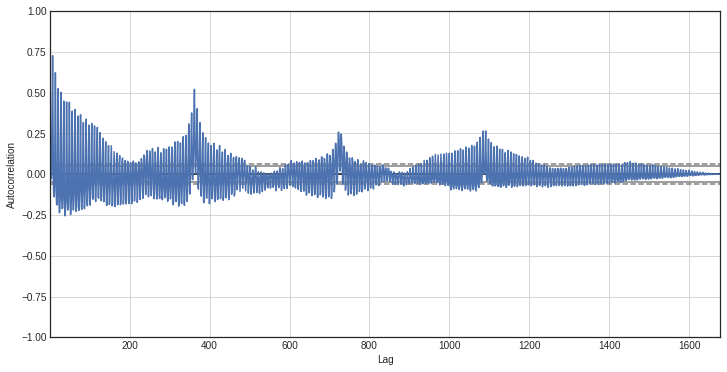

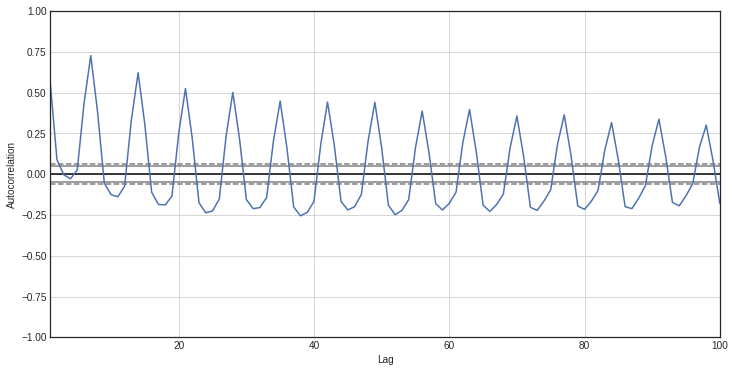

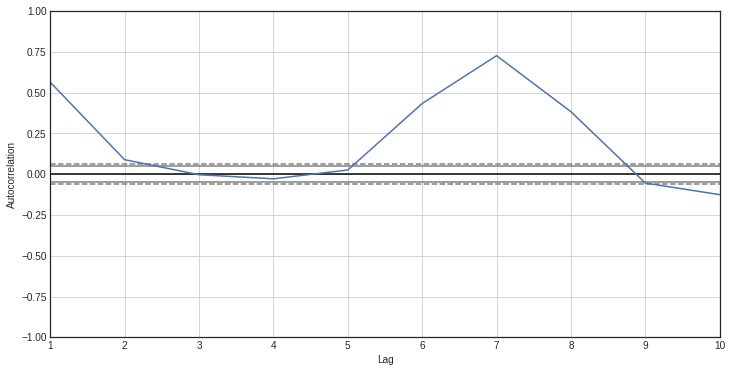

In [44]:
plt.figure(figsize=(12,6))
autocorrelation_plot(ts)
plt.figure(figsize=(12,6))
autocorrelation_plot(ts)
plt.xlim(xmax=100)
plt.figure(figsize=(12,6))
autocorrelation_plot(ts)
plt.xlim(xmax=10)

The highest auto-correlation peaks are every ~365 days and oscillates with a frequency of about 7 days. This corresponds with our intuitive ideas about shopping- that it is a weekly chore. Even though Ecuadorians are most likely to be paid monthly, there is no significant periodicity visible on that scale.  
  
  From the last diagram it seems that the auto-correlation is significant(above the dashed line) for a period of maximum 2 days. All the references then suggest to use 2 for the p parameter. But the stats.model library contains a nifty tool for coefficient selection: arma_order_select_ic(). It performs a grid search with the p and q parameters. Let's see what it says for max parameters 10 and the Bayesian Information Criterion for estimator.

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/conda/lib/python3.7/site-packages/statsmodels/base/mode

The bic prescribes these (p,q) parameters:(5, 5)
The aic prescribes these (p,q) parameters:(7, 8)


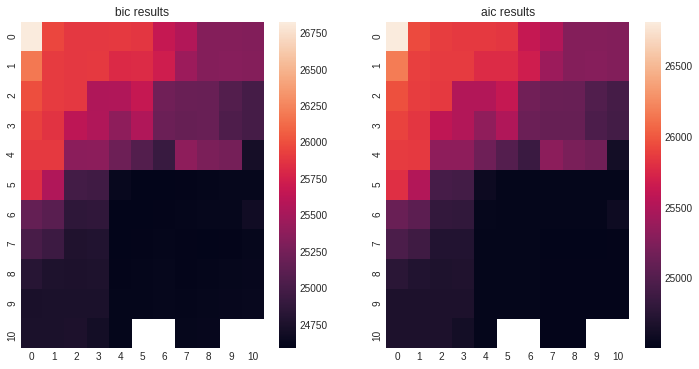

In [45]:
result = arma_order_select_ic(ts, max_ar = 10, max_ma=10, ic=['aic', 'bic'], trend='c', fit_kw=dict(metod='css', maxiter=500))
print('The bic prescribes these (p,q) parameters:{}'.format(result.bic_min_order))
print('The aic prescribes these (p,q) parameters:{}'.format(result.aic_min_order))
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('bic results')
seaborn.heatmap(result.bic)
plt.subplot(1,2,2)
plt.title('aic results')
seaborn.heatmap(result.aic)

With the initial paramters, we are getting many convergence warnings, which may show that the model does not fit the time series well. It may be important to factor out seasonality first, which we shall do in the later part of this analysis. To reduce amount of warnings, we raised the number of iterations to a max of 500, in case of a slow convergence rate. We also plotted heatmaps of the results for both aic and bic for comparision.  
  
  It is clear from the heatmap that we can afford to run the model with parameters (5,0,5).

In [55]:
result

{'aic':               0             1             2             3             4   \
 0   26813.815938  25945.618817  25875.605278  25864.149001  25865.532778   
 1   26173.233709  25891.319470  25865.912558  25865.948051  25780.126935   
 2   25973.932434  25883.710749  25862.195242  25515.330349  25515.831762   
 3   25909.054824  25838.888974  25592.586284  25515.494308  25335.887381   
 4   25866.969926  25860.349625  25325.906574  25327.466337  25155.833586   
 5   25804.716950  25518.960084  24931.335324  24909.107506  24578.310840   
 6   25127.461743  25058.740522  24810.406085  24807.687720  24529.327280   
 7   24962.180186  24887.779859  24717.871863  24714.468972  24524.136675   
 8   24761.853705  24704.537718  24690.957641  24692.956764  24525.689638   
 9   24680.607092  24679.345956  24680.523764  24675.588653  24524.757261   
 10  24680.516906  24680.978768  24682.383208  24622.783801  24523.598180   
 
               5             6             7             8         

In [117]:
ts.head()

date
2013-01-02    4161.0
2013-01-03    3660.0
2013-01-04    3915.0
2013-01-05    4764.0
2013-01-06    4935.0
Name: transactions, dtype: float64

In [119]:
ts.index

Index([2013-01-02, 2013-01-03, 2013-01-04, 2013-01-05, 2013-01-06, 2013-01-07,
       2013-01-08, 2013-01-09, 2013-01-10, 2013-01-11,
       ...
       2017-08-06, 2017-08-07, 2017-08-08, 2017-08-09, 2017-08-10, 2017-08-11,
       2017-08-12, 2017-08-13, 2017-08-14, 2017-08-15],
      dtype='object', name='date', length=1677)

In [78]:
# def add_freq(idx, freq=None):
#     """Add a frequency attribute to idx, through inference or directly.

#     Returns a copy.  If `freq` is None, it is inferred.
#     """

#     idx = idx.copy()
#     if freq is None:
#         if idx.freq is None:
#             freq = pd.infer_freq(idx)
#         else:
#             return idx
#     idx.freq = pd.tseries.frequencies.to_offset(freq)
#     if idx.freq is None:
#         raise AttributeError('no discernible frequency found to `idx`.  Specify'
#                              ' a frequency string with `freq`.')
#     return idx

In [120]:
idx = pd.date_range('2013-01-02', '2017-08-15')
len(idx)

1687

10 days are missing from ts.

In [121]:
ts.index = pd.DatetimeIndex(ts.index)
ts = ts.reindex(idx, fill_value=0)
ts

2013-01-02    4161.0
2013-01-03    3660.0
2013-01-04    3915.0
2013-01-05    4764.0
2013-01-06    4935.0
               ...  
2017-08-11    4009.0
2017-08-12    3825.0
2017-08-13    3741.0
2017-08-14    3606.0
2017-08-15    3581.0
Freq: D, Name: transactions, Length: 1687, dtype: float64

,count,mean,std,min,25%,50%,75%,max
0,1682.0,-0.389897,575.051527,-4603.85114,-250.947617,-49.885284,176.932826,4068.835046


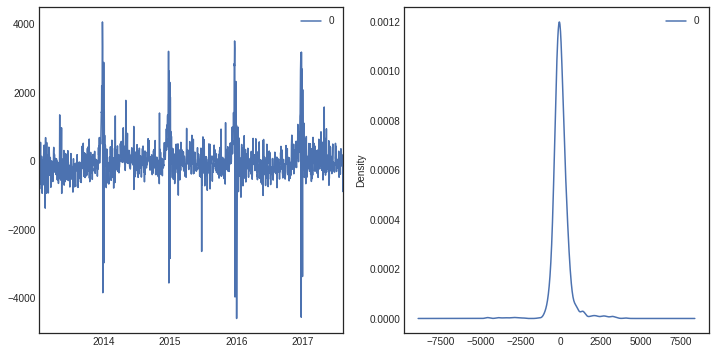

In [128]:
pdq = (5,0,5)
model = ARIMA(ts, order=pdq, freq='D', missing='drop')
model_fit = model.fit(disp=False, method='css', maxiter=100)
#plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
residuals.plot(ax=axes[0])
residuals.plot(kind='kde', ax=axes[1])
residuals.describe().T

In [129]:
model_fit.resid

2013-01-07    500.236081
2013-01-08    264.647237
2013-01-09   -459.092075
2013-01-10   -812.924511
2013-01-11   -273.428228
                 ...    
2017-08-11    169.886457
2017-08-12   -891.618589
2017-08-13   -436.387169
2017-08-14    -44.325408
2017-08-15    102.269327
Freq: D, Length: 1682, dtype: float64

`We can check on the residuals that the model found, which will for sure contain our outlier of mid-2015. We can plot the residuals and thier distribution. We can see that we are getting a Gaussian, centered at 0 with a std of about 380 transactions

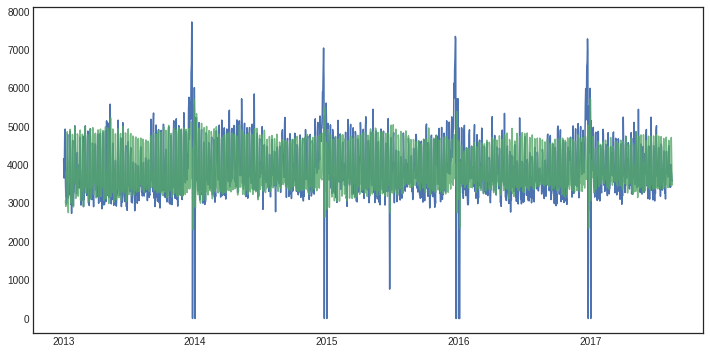

In [133]:
plt.figure(figsize=(12,6))
plt.subplot
plt.plot(ts)
plt.plot(model_fit.fittedvalues, alpha=0.8)

In [132]:
model_fit.fittedvalues

2013-01-07    3069.763919
2013-01-08    2920.352763
2013-01-09    3829.092075
2013-01-10    3794.924511
2013-01-11    3585.428228
                 ...     
2017-08-11    3839.113543
2017-08-12    4716.618589
2017-08-13    4177.387169
2017-08-14    3650.325408
2017-08-15    3478.730673
Freq: D, Length: 1682, dtype: float64

That seems rather good. We can note that the outlier is fitted so that is a sign we may be overfitting. Let us carry on nonetheless and split the data into training and testing so as to see the quality of the predicitons, it gives.

In [152]:
forecast_len = 30
size = int(len(ts)- forecast_len)
train, test = ts[0:size], ts[size: len(ts)]
history = [x for x in train]
predictions = list()
train

2013-01-02    4161.0
2013-01-03    3660.0
2013-01-04    3915.0
2013-01-05    4764.0
2013-01-06    4935.0
               ...  
2017-07-12    3586.0
2017-07-13    3186.0
2017-07-14    3756.0
2017-07-15    4545.0
2017-07-16    4462.0
Freq: D, Name: transactions, Length: 1657, dtype: float64

In [153]:
len(test)

30

In [ ]:
print('Starting the ARIMA predictions \n')
for t in range(len(test)):
    model = ARIMA(train, order = pdq, freq='D')
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('Predicitons finished \n')
    
predictions_series = pd.Series(predictions, index=test.index)


Starting the ARIMA predictions 



In [ ]:
len(predictions)

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Store 47: Transactions')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.plot(ts[-2*forecast_len:], 'o', label = 'observed')
plt.plot(predicitons_series, '-o', label = 'rolling one-step out-of-sample forecast')
plt.legend(loc='upper right')

The results seem rather good. Below is a histogram of te difference in predicitions to see how good a forecast we made. We see that 2/3 errors are below 200 transactions, which is about a 5% error. Not bad for a first try and a month long window.`

In [ ]:
plt.figure(figsize=(12,12))
x = abs(ts[-forecast_len:]- predictions_series)
seaborn.distplot(x, norm_hist=False, rug=True, kde=False)

## Expanding the analysis on store #47 for all stores.

We'd like to improve our forecast and generalize it for all stores. Note that the forecast was rather long due to a lot of non-convergence in the model. We would like to fix that. But before diving in more complex statistical models, we may want to understand a little more of the nature of data that we're manipulating and forecasting.  
  
  ### Two time series?

The fact that holidays transactions volume is higher than the rest of the year is giving us a hint that tis beaviour may be more genralized. After all people have more time to shop during holidays. With this data we have a solid basis to verify our assumption. Let's plot working days and days off with two different colors to see if there is a trend.

In [ ]:
def plot_store_transactions(store_viz, n=30, split=False):
    temp = sales.loc[sales.store_nbr == store_viz].set_index('date')
    plt.figure(figsize=(12,6))
    if split:
        ax1 = plt.subplot(1,2,1)
        plt.scatter(temp.loc[~temp.dayoff].index,
                   temp.loc[~temp.dayoff].transactions, label='working days')
        plt.scatter(temp.loc[temp.dayoff].index,
                   temp.loc[temp.dayoff].transactions, label='off days')
        plt.legend()
        plt.title('Daily Transactions. Store {}, Type {}, Cluster {}'.format(store_viz, 
                                                                            list(stores.loc[stores.store_nbr==store_viz, 'type'])[0],
                                                                            list(stores.loc[stores.store_nbr==store_viz, 'cluster'])[0]))
        ax2 = plt.subplot(1,2,2, sharey=ax1, sharex=ax1)
        plt.plot(temp.loc[~temp.dayoff, 'transactions'].rolling(window=n).mean(), label='working days')
        plt.plot(temp.loc[temp.dayoff, 'transactions'].rolling(window=n).mean(), label='off days')
        plt.title('Store {}: {} day rolling means'.format(store_viz, n))
        plt.legend()
        plt.setp(ax2.get_yticklabels(), visible=False)
    else:
        ax1 = plt.subplot(1,2,1)
        plt.scatter(temp.index, temp.transactions)
        plt.title('Daily Transactions. Store {} Type {} Cluster {}'.format(store_viz, 
                                                                            list(stores.loc[stores.store_nbr==store_viz, 'type'])[0],
                                                                            list(stores.loc[stores.store_nbr==store_viz, 'cluster'])[0]))
        ax2 = plt.subplot(1,2,2, sharey=ax1)
        plt.plot(temp.transactions.rolling(window=n).mean())
        plt.title('Store {}: {} day rolling means'.format(store_viz, n))
        plt.setp(ax2.get_yticklabels(), visible=False)
        plt.show()
        

In [ ]:
plot_store_transactions(47, 30, True)

### Is 'type' a good classifier?  
  
  The plot for store #47 did confirm our assumption, but it would be mistake to assume that is true for all stores. This is the biggest chain in the country and there therefore many stores to analyse, exactly 54 in this dataset. Are they all behaving like store #47? The company provided 2 different classifications of their stores without any indications as to what they correspond to: type and cluster. Would they by any chance correspond to patterns in the transaction volume time series?  
    
   Lets plot them grouped by type to see if a pattern imerges or if we thought to seek our own classification. The following function creates a grid of plots for all our stores of a given type